# Training a crop segmentation neural network using NDVI timeseries

This notebook demonstrates how to train a Unet to segment crops using NDVI timeseries from SpaceEye and CDL as ground-truth data.

The network is trained on chips/patches of NDVI values over the whole year.
We use 37 bands as input, each band contains NDVI values at 10m resolution for one day, and there is a 10-day interval between each band.
Targets come from [CDL](https://data.nal.usda.gov/dataset/cropscape-cropland-data-layer) at 30m resolution and are upsampled to 10m resolution via nearest neighbor interpolation.

Below are the main libraries used for this project and other useful links:
- [Pytorch](https://github.com/pytorch/pytorch) is used as our deep learning framework.
- [TorchGeo](github.com/microsoft/torchgeo) is a library built for training models on geospatial data. We use it to dinamically sample fixed-sized chips to train/evaluate our model. We define torchgeo dataset at lib/datasets.py
- [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) is wrapper over pytorch to reduce boilerplate code for training and evaluating models. We define lightning modules at lib/modules.py.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.
- [Geopandas](https://github.com/geopandas/geopandas) is an extension of the popular pandas library to add support for geographic data. It uses shapely objects in its geometry column, and understands coordinate systems. We use it to visualize the training/validation RoIs. It is also quite useful for transforming geometries between different CRSs.
- [xarray](https://github.com/pydata/xarray) and the extension [rioxarray](https://github.com/corteva/rioxarray) are used for merging and visualizing predictions.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.

# Imports

In [1]:
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import torch
import xarray as xr

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from rioxarray.merge import merge_arrays
from shapely import geometry as shpg
from torchgeo.datasets import BoundingBox
from tqdm.notebook import tqdm

from lib.modules import CropDataModule, SegmentationModel
from lib import constants

In [2]:
def bbox_to_shapely(bbox: BoundingBox) -> shpg.Polygon:
    """
    Convert from torchgeo's BoundingBox to a shapely polygon
    """
    return shpg.box(bbox.minx, bbox.miny, bbox.maxx, bbox.maxy)

def format_timestamp(timestamp: float) -> str:
    return datetime.fromtimestamp(timestamp).strftime("%Y/%m/%d")

# Code organization

The training code is mainly organized into three parts:
- The datasets (lib/datasets.py) inherit from torchgeo and are used to read the data for a desired region. For those familiar with pytorch, these datasets are indexed by a spatiotemporal bounding box instead of integer. If you want to add new datasets, you can use these as a base (and check torchgeo documentation).
- The lightning data module (lib/modules.py) contains the code for creating datasets, samplers (with their respective regions of interest), and data loaders. If you want to change the data split, how to load data, which crops to use, this is probably where you should go to. Also check pytorch-lightning documentation.
- The lightning module (lib/modules.py) contains the code for running/training/evaluating the neural network: instantiating the neural network, training steps, computing metrics, and others. If you want to change the architecure, the loss, and generally how the model is trained, this is probably where you should go to. Also check pytorch-lightning documentation.

# Configuration
`CropDataModule` has the following arguments:
- `img_size`: tuple that defines the size of each chip that is fed to the network. Default: (256, 256)
- `epoch_size`: how many samples are sampled during training for one epoch (this is for the random sampler used in training). Default: 1024
- `batch_size`: how many samples are fed to the network in a single batch. Default: 16
- `num_workers`: how many worker processes to use in the data loader. Default: 4
- `val_ratio`: how much of the data to separate for validation. Default: 0.2
- `positive_indices`: which CDL indices are considered as positive samples. Crop types with a minimum of 1e5 pixels in the RoI are available in the module lib.constants. You can combine multiple constants by adding them (e.g., constants.POTATO_INDEX + constants.CORN_INDEX) Default: constants.CROP_INDICES
- `train_years`: years used for training. Default: [2019]
- `val_years`: years used for validation. Default: [2020]

`SegmentationModel` has the following arguments:
- `lr`: learning rate.
- `weight_decay`: amount of weight decay regularization.
- `encoder_name`: name of the encoder used for the Unet. See [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch) for more information. Default: 'resnet34'
- `encoder_weights`: name of the pretrained weights for the encoder. Use 'imagenet' or None (random weights). See [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch) for more information. Default: 'imagenet'
- `in_channels`: number of input channels of the network. Needs to match the input data. Default: 37
- `classes`: number of output classes. Default: 1
- `num_epochs`: number of training epochs. Used for the cosine annealing scheduler. Default: 10

# Considerations
When training for specific crops you might want to tune the loss (specifically due to imbalance, the amount of positive pixels will be really small compared to negative ones). Feel free to play around with other parameters such as learning rate, weight decay, etc.

In [3]:
# Some constants
ROOT_DIR = "/data/demo"
CHPT_PATH = ""  # Leave empty to train, put path to load checkpoint
# CHPT_PATH = "../lightning_logs/version_0/checkpoints/epoch=9-step=639.ckpt"
CHIP_SIZE = 256
EPOCH_SIZE = 1024
BATCH_SIZE = 16
NUM_WORKERS = 4

# Training hyperparameters
LR = 1e-3  # Learning rate
WD = 0  # Weight decay
MAX_EPOCHS = 10  # How many epochs to train for

In [4]:
# Instantiate the Pytorch-Lightning data module that creates the datasets, split RoIs, and pytorch data loaders
data = CropDataModule(
    ROOT_DIR,
    img_size=(CHIP_SIZE, CHIP_SIZE),
    epoch_size=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    positive_indices=constants.CROP_INDICES
)
# Instantiate the Pytorch-Lightning module that contains the architecture and training code
model = SegmentationModel(lr=LR, weight_decay=WD, num_epochs=MAX_EPOCHS)

data.setup()
# Default checkpoint callback will save a checkpoint at the end of every epoch
callbacks = [ModelCheckpoint()]
# Change to gpus=0 to run on CPU
trainer = Trainer(max_epochs=MAX_EPOCHS, gpus=1, callbacks=callbacks, default_root_dir=ROOT_DIR)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Converting CDLMask resolution from 30.0 to 10.0


# Train/val split
We can visualize the training a validation split but sampling boxes as shown below. By default, we separate 20% of the available data for validation (shown in orange). The rest is used for training. Additionally, we use data from 2019 to train, and evaluate the model on 2020.

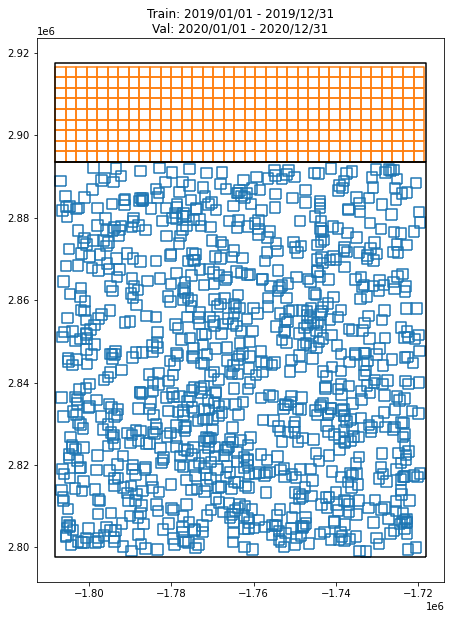

In [5]:
train_roi = data.train_dataloader().sampler.roi
val_roi = data.val_dataloader().sampler.roi

plt.figure(figsize=(10, 10))
ax = plt.gca()
gpd.GeoSeries([bbox_to_shapely(b) for b in data.train_dataloader().sampler]).boundary.plot(ax=ax, color="C0")
gpd.GeoSeries([bbox_to_shapely(b) for b in data.val_dataloader().sampler]).boundary.plot(ax=ax, color="C1")
gpd.GeoSeries(bbox_to_shapely(train_roi)).boundary.plot(ax=ax, color="black")
gpd.GeoSeries(bbox_to_shapely(val_roi)).boundary.plot(ax=ax, color="black")
plt.title(
    f"Train: {format_timestamp(train_roi.mint)} - {format_timestamp(train_roi.maxt)}\n"
    f"Val: {format_timestamp(val_roi.mint)} - {format_timestamp(val_roi.maxt)}"
)
plt.show()

# Train/load model
We can train the model by calling the trainer's fit method and passing the lightning module and data module.

In [6]:
if CHPT_PATH and os.path.exists(CHPT_PATH):
    # Load model
    model = SegmentationModel.load_from_checkpoint(CHPT_PATH)
else:
    # Train it now
    trainer.fit(model, data)

/home/azureuser/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | Unet              | 24.5 M
1 | loss          | BCEWithLogitsLoss | 0     
2 | train_metrics | MetricCollection  | 0     
3 | val_metrics   | MetricCollection  | 0     
----------------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
98.172    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/azureuser/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/home/azureuser/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/azureuser/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate model
We can evaluate the model by calling the validate method from the Pytorch-Lightning trainer. This will compute and print metrics for the validation set. Additionally, we plot the Precision-Recall curve, and display the operating point for a threshold of 0.5.

In [7]:
trainer.validate(model, data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9141029715538025,
 'val_ap': 0.9705705642700195,
 'val_loss': 0.2115224450826645}
--------------------------------------------------------------------------------


[{'val_loss': 0.2115224450826645,
  'val_acc': 0.9141029715538025,
  'val_ap': 0.9705705642700195}]

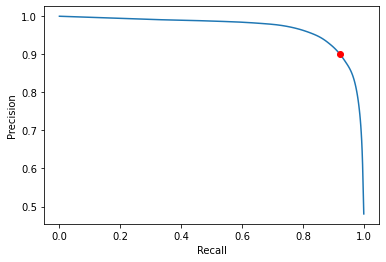

In [8]:
FPs = model.val_metrics["ap"].FPs
TPs = model.val_metrics["ap"].TPs
FNs = model.val_metrics["ap"].FNs

Re = TPs / (TPs + FNs)
Pr = TPs / (TPs + FPs)

plt.plot(Re[0], Pr[0])
plt.plot(Re[0, 50], Pr[0, 50], 'ro')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Predicting over large areas
Since the model operates on relatively small chips, to produce a prediction map over a large area, we need to make several predictions and merge them afterwards.
We use xarray, rioxarray, and rasterio to create geo-referenced data that is then merged into a single DataArray.

Predictions for the whole validation RoI are shown bellow (bright yellow indicating high confidence of crop, and deep blue indicating low confidence), along with the ground-truth from CDL.

In [9]:
# Define how rasterio should merge the chips (we're taking the maximum)
def custom_merge_fun(old_data, new_data, old_nodata, new_nodata, index=None, roff=None, coff=None):
    old_data[:] = np.maximum(old_data, new_data)

In [10]:
# We need to set the model to evaluation mode and transfer it to GPU manually since we are not using Pytorch-Lightning here
model.to("cuda")
model.eval()
geo_preds = []
for batch in tqdm(data.val_dataloader()):
    x = batch["image"].to("cuda")
    with torch.inference_mode():
        preds = model(x)
    # Move predictions to CPU and transform to numpy array
    preds = preds.to("cpu").numpy()
    # Convert regions for each prediction chip into numpy array
    boxes = np.array([tuple(b) for b in batch["bbox"]])[:, :4]
    # Create a geo-referenced DataArray for each chip and save into list
    geo_preds += [xr.DataArray(pred, coords={"band": [1], "y": np.linspace(b[3]-5, b[2]+5, 256), "x": np.linspace(b[0]+5, b[1]-5, 256)}) for pred, b in zip(preds, boxes)]

# Add the CRS for each chip (we are using EPSG:5070)
for g in geo_preds:
    g.rio.write_crs(data.val_dataset.crs, inplace=True)
# Merge predictions into a single large array using our custom merging function
# For more information about merging functions see:
# https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html#rasterio.merge.merge
merged_preds = merge_arrays(geo_preds, method=custom_merge_fun)
# Take the sigmoid
sig_preds = (1/(1 + np.exp(-merged_preds)))

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
# Get the ground-truth for the same location
b = sig_preds.rio.bounds()
merged_gt = data.val_dataset.datasets[1][BoundingBox(minx=b[0], maxx=b[2], miny=b[1], maxy=b[3], mint=val_roi.mint, maxt=val_roi.maxt)]
merged_gt = xr.DataArray(merged_gt["mask"], coords={"band": [1], "y": np.linspace(merged_gt["bbox"][3]-5, merged_gt["bbox"][2]+5, merged_gt["mask"].shape[1]), "x": np.linspace(merged_gt["bbox"][0]+5, merged_gt["bbox"][1]-5, merged_gt["mask"].shape[2])})

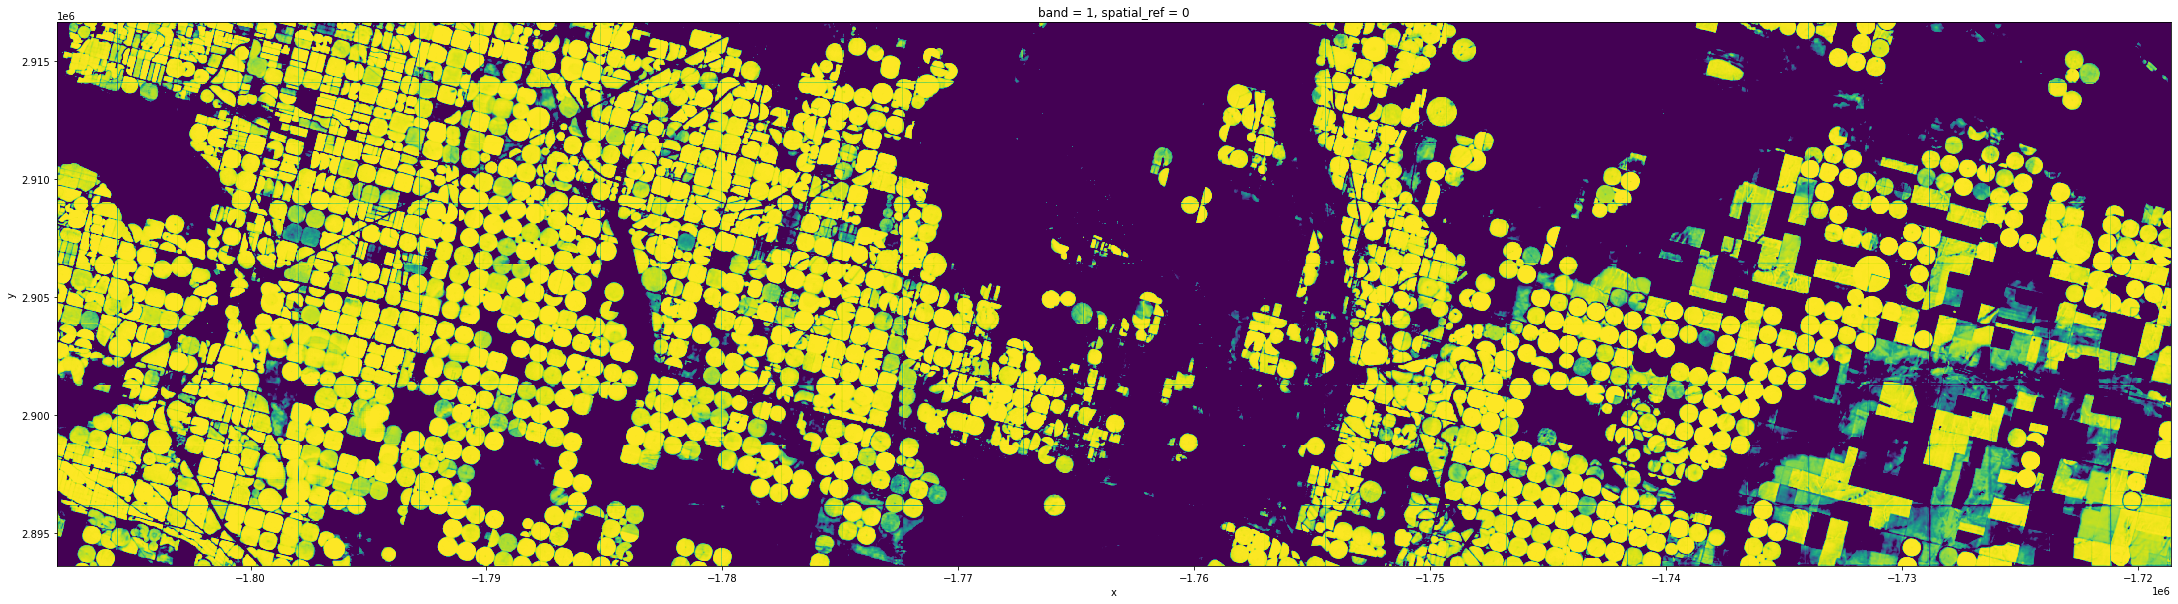

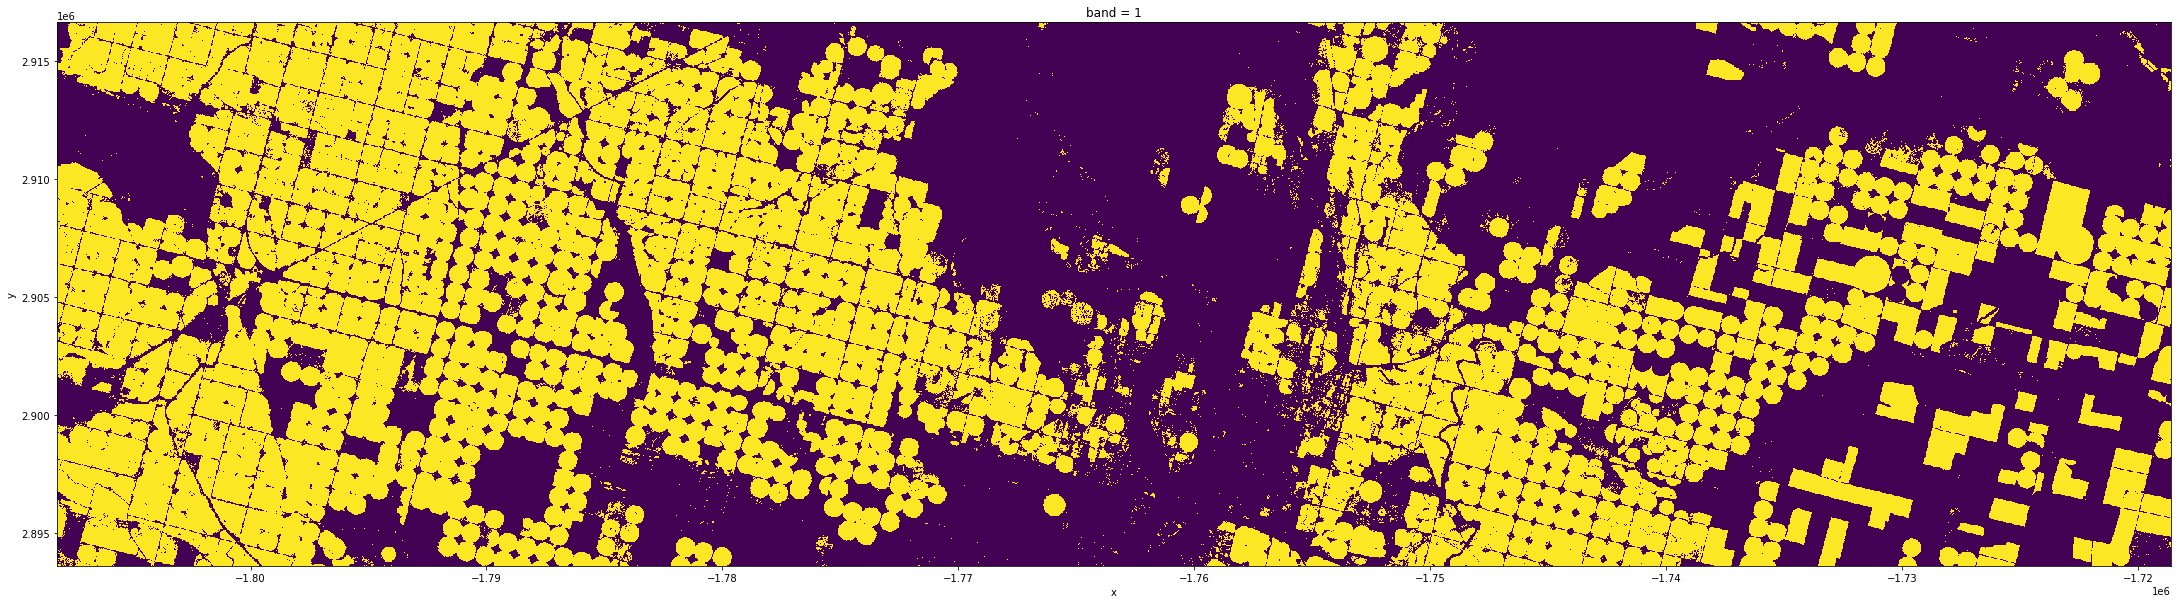

In [12]:
# Plot predictions
sig_preds.plot(size=10, aspect=merged_preds.shape[2]/merged_preds.shape[1], add_colorbar=False)
plt.gca().set_aspect("equal")
plt.show()
# Plot ground-truth mask from CDL
merged_gt.plot(size=10, aspect=merged_preds.shape[2]/merged_preds.shape[1], add_colorbar=False)
plt.gca().set_aspect("equal")
plt.show()